In [20]:
import rasterio
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
import pandas as pd

df = pd.read_csv('export_fc.csv')

In [19]:
df

,system:index,B2,B3,B4,B8,remapped,.geo
0,0_0_0,745,1034,1414,1915,7,NaN
1,2_0_0,546,898,1247,2204,5,NaN
2,4_0_0,436,722,960,1823,7,NaN
3,5_0_0,1189,1554,1706,1868,7,NaN
4,6_0_0,1691,2423,2610,2790,7,NaN
...,...,...,...,...,...,...,...
4089,4994_0_0,773,1080,1455,1930,6,NaN
4090,4995_0_0,1757,2215,2385,2261,6,NaN
4091,4997_0_0,841,1171,1276,1490,7,NaN
4092,4998_0_0,1973,2529,3067,3388,7,NaN


In [8]:
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 

In [12]:
X = df[['B2','B3','B4','B8']]
y = df['remapped']

In [13]:
# Now for train and test split (80% of  dataset into  training set and  other 20% into test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [39]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
clf.score(X_test, y_test)

0.818070818070818

In [77]:
b2 = rasterio.open('images/imageToDriveExample.tif').read(1)
b3 = rasterio.open('images/imageToDriveExample.tif').read(2)
b4 = rasterio.open('images/imageToDriveExample.tif').read(3)
b8 = rasterio.open('images/imageToDriveExample.tif').read(4)
stacked_bands = np.stack([b2, b3, b4, b8])

In [314]:
from tqdm import tqdm

np.random.seed = 42

w,h = 100,100

nsims = 100
stack = []
for i in tqdm(range(nsims)):
    noise = np.random.normal(0, 1, (w,h))
    X_inf = np.moveaxis(stacked_bands[:,:w,:h]+noise,0,-1).reshape(-1,4)
    preds = clf.predict(X_inf)

    stack.append(np.squeeze(preds.reshape(w, h, -1)))

100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


In [315]:
from scipy.stats import mode

mode_res = np.squeeze(mode(np.array(stack),0).mode)
mode_unc = np.squeeze(mode(np.array(stack),0).count / nsims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


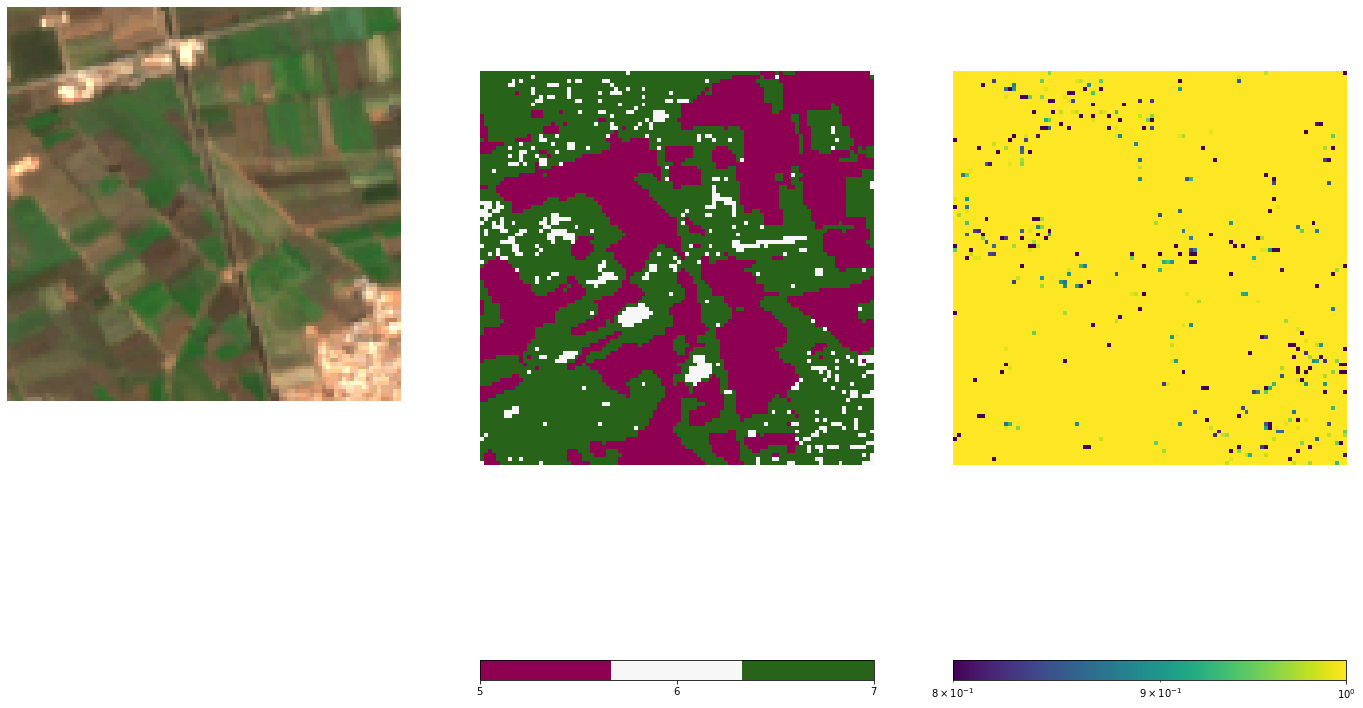

In [316]:
import matplotlib
cmap = cm.get_cmap('PiYG', 3)    # 11 discrete colors

fig = plt.figure(figsize=(24,24))
plt.subplot(131)
plt.imshow(np.moveaxis(stacked_bands[:,:w,:h][[2,1,0]],0,-1)/2000.)
plt.axis('off')
plt.subplot(132)
mat = plt.imshow(mode_res, cmap=cmap)
plt.axis('off')
plt.colorbar(mat, ticks=np.arange(np.min(mode_res),np.max(mode_res)+1), orientation='horizontal')
plt.subplot(133)
mat2 = plt.imshow(mode_unc, cmap='viridis', vmin=0.8, vmax=1, norm=matplotlib.colors.LogNorm(vmin=0.95, vmax=1))
plt.colorbar(mat2, orientation='horizontal')
plt.axis('off')
plt.savefig('monte_carlo.png', dpi=300, bbox_inches='tight', transparent=True)

In [271]:
mode_unc[np.where(np.sum(np.diff(np.array(stack)))>0)].shape

(0, 100)

(138,) (138,)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f6ced74ed00>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6ced6db400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6ced74e9a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6ced6dbac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6ced6dbdc0>],
 'means': []}

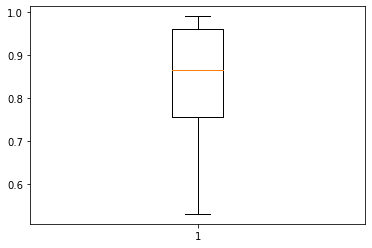

In [313]:
t = mode_unc[np.where(np.sum(np.diff(np.array(stack)),-1)>1.95)]
t = t[np.where(t!=1)]
x = mode_res[np.where(np.sum(np.diff(np.array(stack)),-1)>1.95)][np.where(t!=1)]
print(t.shape, x.shape)
plt.boxplot(t)

(array([3.000e+00, 2.200e+01, 4.000e+01, 3.700e+01, 3.900e+01, 6.400e+01,
        6.200e+01, 8.100e+01, 1.060e+02, 4.909e+03]),
 array([0.43 , 0.487, 0.544, 0.601, 0.658, 0.715, 0.772, 0.829, 0.886,
        0.943, 1.   ]),
 <a list of 10 Patch objects>)

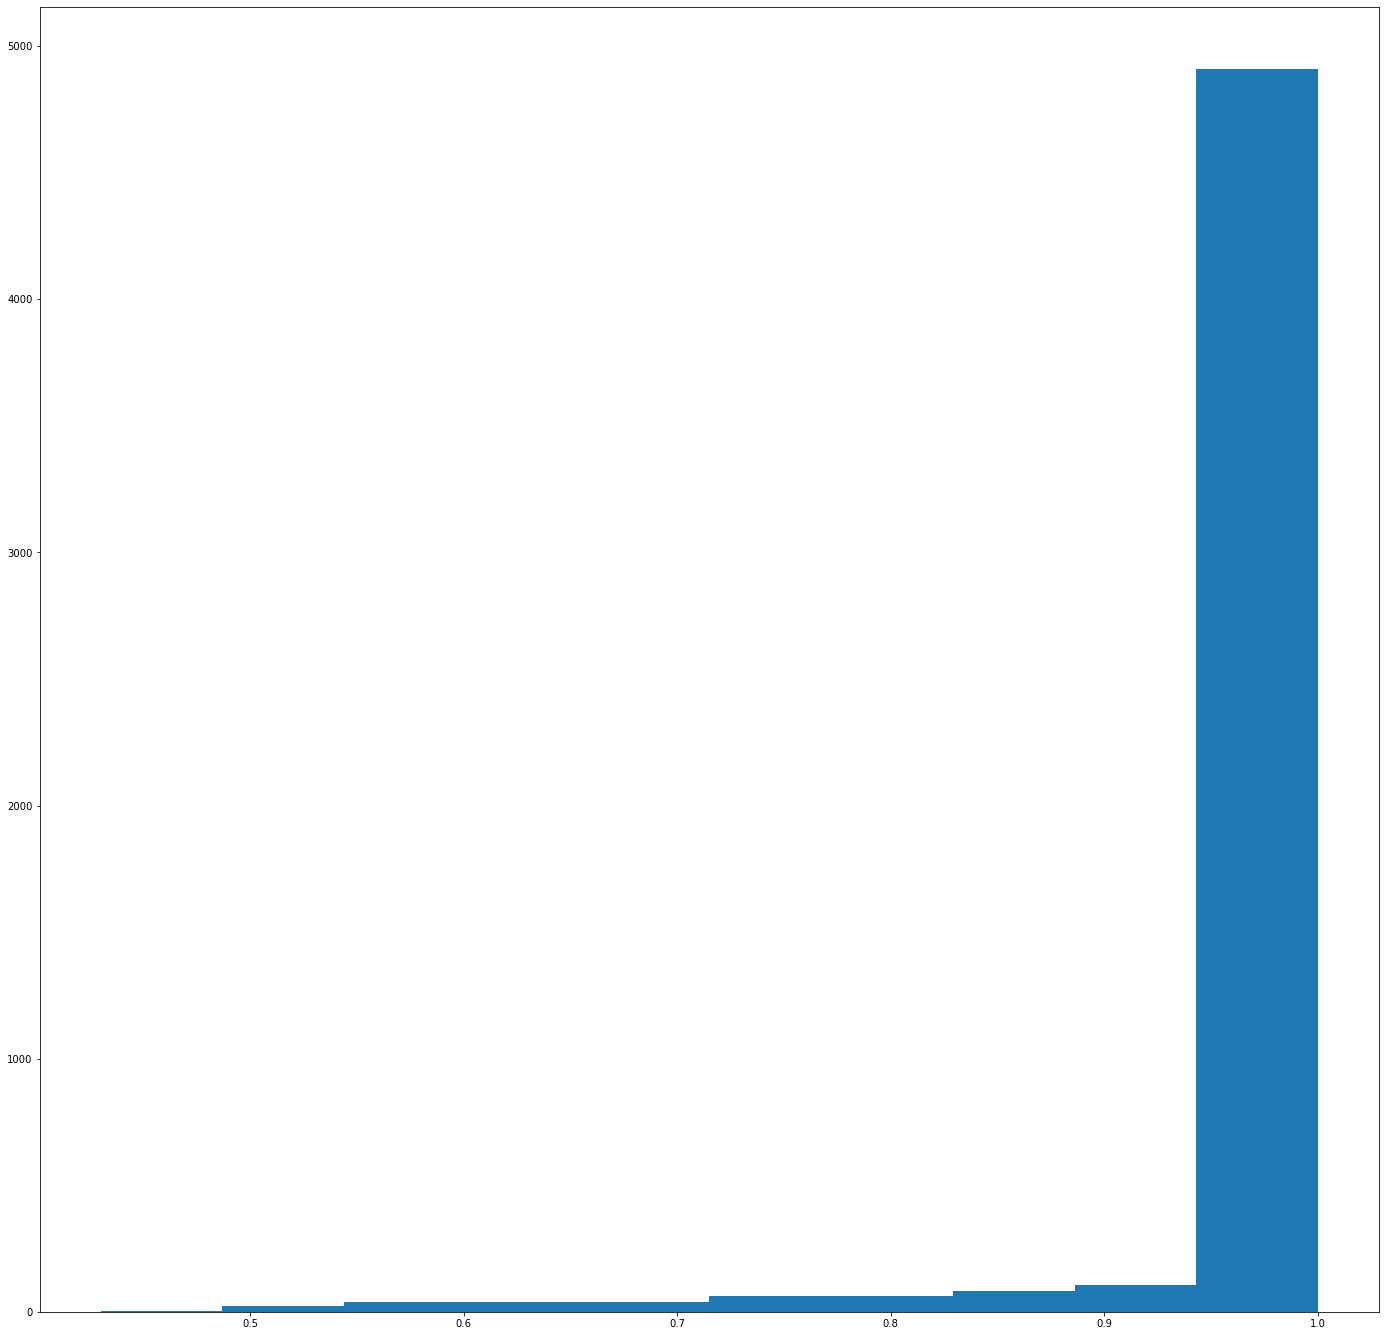

In [264]:
#plt.boxplot(mode_unc[np.where(mode_res==5)].ravel())
plt.figure(figsize=(24,24))
plt.hist(mode_unc[np.where(mode_res==7)].ravel())

In [210]:
plt.imshow(np.squeeze(mode(np.array(stack),0).count))

KeyboardInterrupt: 

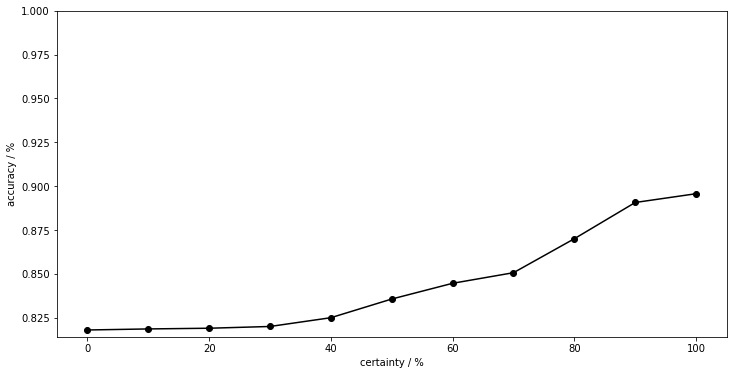

In [230]:
plt.figure(figsize=(12,6))

acc = [0.818070818070818,0.818670818070818,0.819070818070818,0.820070818070818,0.825070818070818,\
      0.83570818070818,0.844670818070818,0.85070818070818,0.870070818070818,0.89070818070818,0.89570818070818]
certainty = np.arange(0,110,10)
plt.plot(certainty, acc, 'ko-')
plt.ylim(top=1)
plt.xlabel('certainty / %')
plt.ylabel('accuracy / %')
plt.show()

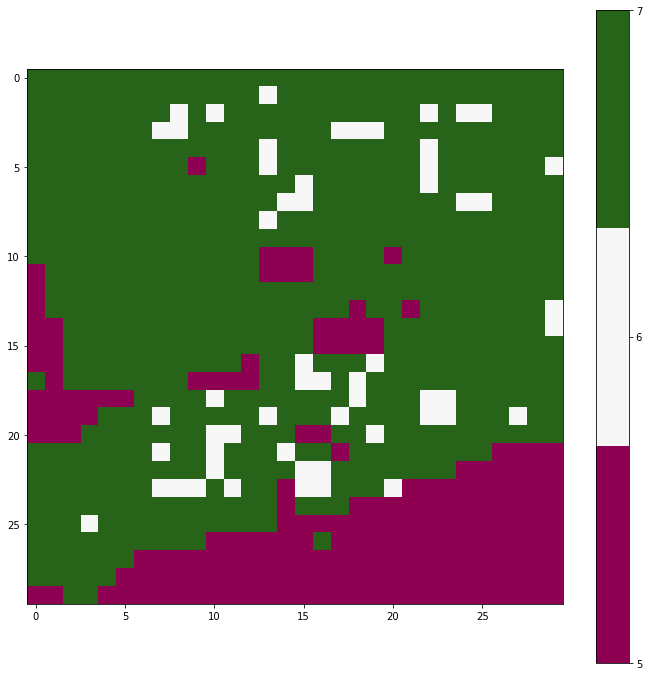

In [106]:
cmap = cm.get_cmap('PiYG', 3)    # 11 discrete colors

plt.figure(figsize=(12,12))
mat = plt.imshow(np.squeeze(preds.reshape(w, h, -1)), cmap=cmap)
plt.colorbar(mat, ticks=np.arange(np.min(preds),np.max(preds)+1))